# Notebook to explain the mechanics of Smoothness Harmocis

### Example of Subject 1 

In [1]:
### Importing the time series (preprocessed fMRI time series)

import numpy as np


ts_allsubj = np.load("../../dataset/age_development_msdl_originTS.py.npy")

sFC_allsubj = np.load('../../dataset/age_development_sFC.npy')

print (ts_allsubj.shape) ### 155 subjects 

(155, 168, 39)


In [2]:
from pygsp import graphs
import scipy as sp
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

## Taking first subject data as an example to compute the SH_temp and SH_spat

f = ts_allsubj[0].T ### First subject signal $f$ [N,T] matrix

sFC = sFC_allsubj[0] ### First subject sFC [N, N]

## Computing the graph laplacian U[N,N]

w = sFC.reshape(39,39)
w = w + w.T
np.fill_diagonal(w,0)
g = graphs.Graph(w)

eigenvalue, eigenvectors= eigsh(g.L, k=1, which='SA') ## slow-varying U_{k=1}

    
print (eigenvectors.shape) ### U_{k=1} [N,1]

(39, 1)


## Temporal smoothness index

In [3]:
SH_temp = (f * eigenvectors).T @ (f)
SH_temp.shape

(168, 168)

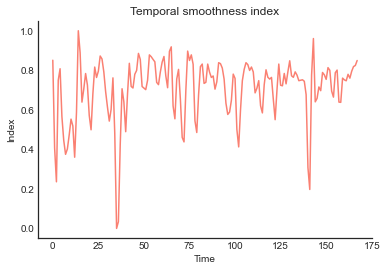

In [4]:
#### Plotting the diag(SH_temp)
### Normalise the SH_temp score into [0, 1] range

from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
#fig = plt.figure(figsize=(8,4), dpi = 300)

SH_temp_norm = preprocessing.MinMaxScaler().fit_transform(np.diag(SH_temp).reshape((168,1)))
plt.title('Temporal smoothness index')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time')
plt.ylabel('Index')
plt.plot(SH_temp_norm, c= 'salmon')

## Spatial smoothness map

In [5]:
SH_spat = eigenvectors * f @ f.T
SH_spat.shape

(39, 39)

In [6]:
SH_spat_norm = preprocessing.MinMaxScaler().fit_transform(np.diag(SH_spat.T).reshape((39,1)))

/usr/local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/usr/local/lib/python3.7/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


<Figure size 2400x1200 with 0 Axes>

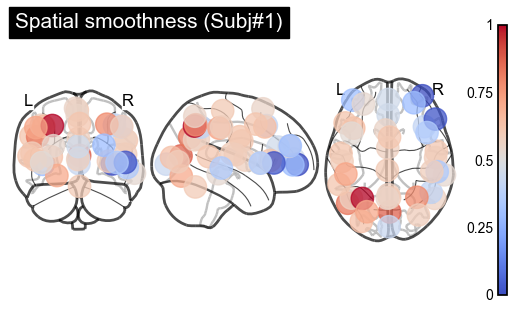

In [7]:
#### Plotting the diag(SH_spat)
### Normalise the SH_spat score into [0, 1] range, SH_spat_norm


from nilearn import datasets
from nilearn import plotting
import matplotlib as mpl
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8,4), dpi = 300)

msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords


plt.style.use('seaborn-white')
fig = plt.figure(figsize=(5,3), dpi = 100)
plotting.plot_markers(SH_spat_norm, msdl_coords,colorbar=True, node_cmap= 'coolwarm',
                     node_size=260, alpha = 0.75, figure = fig, 
                      title= 'Spatial smoothness (Subj#1)')

# Additional Graph_2_V implementation for SVM classification 


In [13]:
from sklearn import preprocessing
from networkx import from_numpy_matrix

G = []
min_max_scaler = preprocessing.MinMaxScaler()

for i in range(155):
    min_max_scaler = preprocessing.MinMaxScaler()
    W = min_max_scaler.fit_transform(sFC_allsubj[i])

    tri = np.triu(W)
    new = tri + tri.T - np.diag(np.diag(tri))
    np.fill_diagonal(new, 0)
    tem = from_numpy_matrix(new)
    G.append(tem)
    


In [14]:
G

In [15]:
### Graph Embedding 
### Making the graph features to be same with sFC/Smoothness harmonics == 1521

from karateclub.graph_embedding import Graph2Vec

model = Graph2Vec(dimensions=1521)
model.fit(G)

In [16]:
model.get_embedding().shape

(155, 1521)

In [17]:
label_0 = np.zeros(33)
label_1 = np.ones(122)

label = np.concatenate((label_0, label_1), axis = 0)
label.shape

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(model.get_embedding(), 
                                                    label, test_size=0.8, random_state=42)



# Preprocess the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the classifier
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.3f}')

Accuracy: 0.766
